# Embedding + first classifier

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold,train_test_split,cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv("dca_for_classifier.csv")

In [4]:
data

,גוף המסמך,מספר תיק,Outcome of case,binary_outcome
0,"['פסק-דין בתיק רע""פ 7861/03 בבית המשפט העליון ...",7861/03,G R,1.0
1,"['פסק-דין בתיק רע""פ 8337/04 בבית המשפט העליון ...",8337/04,G R,1.0
2,"['החלטה בתיק רע""פ 7896/04 בבית המשפט העליון רע...",7896/04,G A,1.0
3,"['פסק-דין בתיק רע""פ 2038/04 בבית המשפט העליון ...",2038/04,G R,1.0
4,"['פסק-דין בתיק רע""פ 5978/04 בבית המשפט העליון ...",5978/04,G A,1.0
...,...,...,...,...
726,"['החלטה בתיק רע""פ 3076/07 בבית המשפט העליון רע...",3076/07,D,0.0
727,"['החלטה בתיק רע""פ 6415/07 בבית המשפט העליון רע...",6415/07,D A,0.0
728,"['החלטה בתיק רע""פ 825/07 בבית המשפט העליון רע""...",825/07,D A,0.0
729,"['החלטה בתיק רע""פ 4180/07 בבית המשפט העליון רע...",4180/07,D A,0.0


binary_outcome
0.0    680
1.0     46
Name: count, dtype: int64


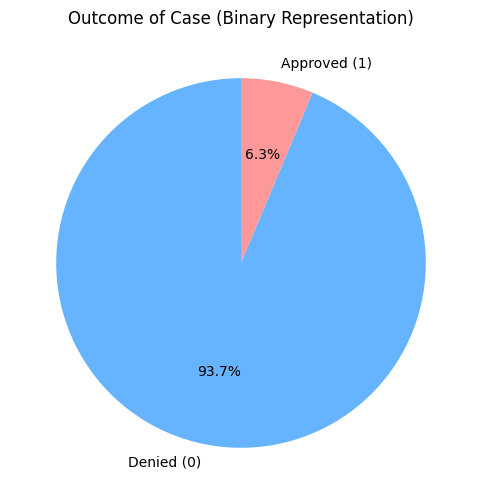

In [5]:
binary_counts = data['binary_outcome'].value_counts()
print(binary_counts)
labels = ['Denied (0)','Approved (1)']

plt.figure(figsize=(6, 6))
plt.pie(binary_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title('Outcome of Case (Binary Representation)')

plt.show()

In [6]:

tokenizer = AutoTokenizer.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")
model = AutoModel.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")

# פונקציה שמקבלת טקסט ומחזירה את האימבדינג כוקטור
def get_embeddings(text):
    # המרת הטקסט לפורמט מתאים למודל
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # חישוב האימבדינג של המודל
    outputs = model(**inputs)
    # חישוב ממוצע הוקטורים עבור כל טקסט
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings[0]

# הסרת שורות עם ערכים חסרים בעמודת הטקסט או בעמודת המטרה
data = data.dropna(subset=["גוף המסמך", "binary_outcome"])

# עדכון עמודת המטרה ואימבדינג לאחר הסרת הערכים החסרים
y = data["binary_outcome"].values
embeddings = np.array([get_embeddings(text) for text in data["גוף המסמך"]])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.86M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]


## Training

In [7]:

classifier = LogisticRegression(random_state=42, max_iter=1000)

# הגדרת Stratified K-Fold עם 5 פולדים כדי לשמר את יחס הכיתות
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# הגדרת מדדי הביצועים
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1)
}

cv_results = cross_validate(classifier, embeddings, y, cv=cv, scoring=scoring)

print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
print("Mean Accuracy:", cv_results['test_accuracy'].mean())
print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())


Cross-Validation Accuracy: [0.97260274 0.97241379 0.96551724 0.96551724 0.9862069 ]
Mean Accuracy: 0.9724515824279643
Cross-Validation Precision for Class 1: [0.875      1.         0.83333333 1.         1.        ]
Mean Precision for Class 1: 0.9416666666666668
Cross-Validation Recall for Class 1: [0.7        0.55555556 0.55555556 0.44444444 0.77777778]
Mean Recall for Class 1: 0.6066666666666667
Cross-Validation F1 Score for Class 1: [0.77777778 0.71428571 0.66666667 0.61538462 0.875     ]
Mean F1 Score for Class 1: 0.7298229548229548


### Loss function - class weight tunning

In [8]:
# הגדרת מסווג לוגיסטי עם משקולות כיתות
classifier = LogisticRegression(random_state=42, max_iter=1000, class_weight={0: 1, 1: 5})

cv_results = cross_validate(classifier, embeddings, y, cv=cv, scoring=scoring)

print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
print("Mean Accuracy:", cv_results['test_accuracy'].mean())
print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())


Cross-Validation Accuracy: [0.97945205 0.95862069 0.95172414 0.97241379 0.99310345]
Mean Accuracy: 0.9710628247520076
Cross-Validation Precision for Class 1: [0.88888889 0.71428571 0.6        1.         1.        ]
Mean Precision for Class 1: 0.8406349206349206
Cross-Validation Recall for Class 1: [0.8        0.55555556 0.66666667 0.55555556 0.88888889]
Mean Recall for Class 1: 0.6933333333333332
Cross-Validation F1 Score for Class 1: [0.84210526 0.625      0.63157895 0.71428571 0.94117647]
Mean F1 Score for Class 1: 0.7508292790800531


## UNDERSAMPLING


In [9]:
# הגדרת undersampler עם יחס של 60-40 לטובת קלאס 0
undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=42)

# ביצוע undersampling
X_resampled, y_resampled = undersampler.fit_resample(embeddings, y)

# הגדרת מסווג וביצוע Cross Validation על הנתונים המדוללים
cv_results_resampled = cross_validate(classifier, X_resampled, y_resampled, cv=cv, scoring=scoring)

print("Cross-Validation Accuracy (after undersampling):", cv_results_resampled['test_accuracy'])
print("Mean Accuracy (after undersampling):", cv_results_resampled['test_accuracy'].mean())
print("Cross-Validation Precision for Class 1 (after undersampling):", cv_results_resampled['test_precision'])
print("Mean Precision for Class 1 (after undersampling):", cv_results_resampled['test_precision'].mean())
print("Cross-Validation Recall for Class 1 (after undersampling):", cv_results_resampled['test_recall'])
print("Mean Recall for Class 1 (after undersampling):", cv_results_resampled['test_recall'].mean())
print("Cross-Validation F1 Score for Class 1 (after undersampling):", cv_results_resampled['test_f1'])
print("Mean F1 Score for Class 1 (after undersampling):", cv_results_resampled['test_f1'].mean())


Cross-Validation Accuracy (after undersampling): [0.84       0.8        0.91666667 0.79166667 0.91666667]
Mean Accuracy (after undersampling): 0.853
Cross-Validation Precision for Class 1 (after undersampling): [0.72727273 0.77777778 0.88888889 0.75       0.81818182]
Mean Precision for Class 1 (after undersampling): 0.7924242424242425
Cross-Validation Recall for Class 1 (after undersampling): [0.88888889 0.7        0.88888889 0.66666667 1.        ]
Mean Recall for Class 1 (after undersampling): 0.8288888888888888
Cross-Validation F1 Score for Class 1 (after undersampling): [0.8        0.73684211 0.88888889 0.70588235 0.9       ]
Mean F1 Score for Class 1 (after undersampling): 0.8063226694186447


## combine undersampling with class weights

In [10]:
# רשימת משקלים שנבדוק עבור קלאס 1
class_weights = [2, 3, 4, 5]
results = []

# הגדרת undersampler עם יחס של 60-40 לטובת קלאס 0
undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(embeddings, y)

# הגדרת Cross Validation ומדדים
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1)
}

# ביצוע בדיקה עבור כל משקל
for weight in class_weights:
    # הגדרת מסווג לוגיסטי עם המשקל הנוכחי לקלאס 1
    classifier = LogisticRegression(random_state=42, max_iter=1000, class_weight={0: 1, 1: weight})

    # ביצוע Cross Validation על הנתונים המדוללים עם המשקל הנוכחי
    cv_results_combined = cross_validate(classifier, X_resampled, y_resampled, cv=cv, scoring=scoring)

    # שמירת התוצאות
    results.append({
        "weight": weight,
        "mean_accuracy": cv_results_combined['test_accuracy'].mean(),
        "mean_precision_class_1": cv_results_combined['test_precision'].mean(),
        "mean_recall_class_1": cv_results_combined['test_recall'].mean(),
        "mean_f1_class_1": cv_results_combined['test_f1'].mean()
    })

# הצגת התוצאות
for result in results:
    print(f"Class Weight for 1: {result['weight']}")
    print(f"Mean Accuracy: {result['mean_accuracy']}")
    print(f"Mean Precision for Class 1: {result['mean_precision_class_1']}")
    print(f"Mean Recall for Class 1: {result['mean_recall_class_1']}")
    print(f"Mean F1 Score for Class 1: {result['mean_f1_class_1']}")
    print("--------------------------------------------------")

Class Weight for 1: 2
Mean Accuracy: 0.869
Mean Precision for Class 1: 0.845
Mean Recall for Class 1: 0.8066666666666666
Mean F1 Score for Class 1: 0.8218094255245958
--------------------------------------------------
Class Weight for 1: 3
Mean Accuracy: 0.8613333333333333
Mean Precision for Class 1: 0.8146464646464647
Mean Recall for Class 1: 0.8288888888888888
Mean F1 Score for Class 1: 0.816780185758514
--------------------------------------------------
Class Weight for 1: 4
Mean Accuracy: 0.853
Mean Precision for Class 1: 0.7924242424242425
Mean Recall for Class 1: 0.8288888888888888
Mean F1 Score for Class 1: 0.8063226694186447
--------------------------------------------------
Class Weight for 1: 5
Mean Accuracy: 0.853
Mean Precision for Class 1: 0.7924242424242425
Mean Recall for Class 1: 0.8288888888888888
Mean F1 Score for Class 1: 0.8063226694186447
--------------------------------------------------


### Best model

In [11]:

# הגדרת undersampler עם יחס של 60-40 לטובת קלאס 0
undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(embeddings, y)

# הגדרת מסווג לוגיסטי עם משקל של 3 עבור קלאס 1
classifier = LogisticRegression(random_state=42, max_iter=1000, class_weight={0: 1, 1: 3})

# הגדרת מדדים לקרוס ולידציה
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1)
}

# ביצוע Cross Validation
cv_results = cross_validate(classifier, X_resampled, y_resampled, cv=5, scoring=scoring)

# חיזוי תוויות על כל קפל לצורך קונפיושן מטריקס
y_pred = cross_val_predict(classifier, X_resampled, y_resampled, cv=5)
conf_matrix = confusion_matrix(y_resampled, y_pred)

print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
print("Mean Accuracy:", cv_results['test_accuracy'].mean())
print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

tn, fp, fn, tp = conf_matrix.ravel()

# הדפסת הקונפיושן מטריקס עם תוויות
print("Confusion Matrix with Labels:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

print("\nConfusion Matrix:")
print(f"[[{tn} {fp}]")
print(f" [{fn} {tp}]]")


Cross-Validation Accuracy: [0.84       0.88       0.83333333 0.91666667 0.875     ]
Mean Accuracy: 0.869
Cross-Validation Precision for Class 1: [0.72727273 0.81818182 0.85714286 0.88888889 0.8       ]
Mean Precision for Class 1: 0.8182972582972583
Cross-Validation Recall for Class 1: [0.88888889 0.9        0.66666667 0.88888889 0.88888889]
Mean Recall for Class 1: 0.8466666666666665
Cross-Validation F1 Score for Class 1: [0.8        0.85714286 0.75       0.88888889 0.84210526]
Mean F1 Score for Class 1: 0.8276274018379282
Confusion Matrix with Labels:
True Negatives (TN): 67
False Positives (FP): 9
False Negatives (FN): 7
True Positives (TP): 39

Confusion Matrix:
[[67 9]
 [7 39]]


In [12]:
# הגדרת פונקציה לעיצוב טקסט
def format_text(text, line_length=80):
    """
    פורמט טקסט כך שיהיה נוח לקריאה עם שורות שאורכן מוגבל.
    """
    import textwrap
    return "\n".join(textwrap.wrap(text, width=line_length))


In [13]:
# התאמת האינדקסים של y_resampled לעמודות המקוריות
resampled_indices = undersampler.sample_indices_

# ווידוא התאמה: מיפוי y_resampled לעמודת binary_outcome
binary_outcome_resampled = data.iloc[resampled_indices]["binary_outcome"].values

if not np.array_equal(y_resampled, binary_outcome_resampled):
    raise ValueError("Mismatch between y_resampled and resampled binary_outcome values!")

# חיזוי תוויות על כל קפל לצורך זיהוי FN
y_pred = cross_val_predict(classifier, X_resampled, y_resampled, cv=5)

# איתור האינדקסים של FN - תווית אמיתית היא 1 והתחזית היא 0
fn_indices = np.where((y_resampled == 1) & (y_pred == 0))[0]

# מיפוי האינדקסים של FN לאינדקסים המקוריים של הנתונים
original_fn_indices = resampled_indices[fn_indices]

# קריאת פסקי הדין והערכים בעמודות "Outcome of case", "binary_outcome", ו-"Predicted" עבור הדוגמאות שמזוהות כ-FN
false_negative_rows = data.iloc[original_fn_indices]
false_negative_predicted = y_pred[fn_indices]  # התחזיות של המודל עבור FN

# ווידוא סינכרון מוחלט של האינדקסים
if len(false_negative_rows) != len(false_negative_predicted):
    raise ValueError("Mismatch between FN rows and predicted labels!")

# הדפסת פסקי הדין של FN בצורה מפורמטת עם הערכים המקוריים והתחזית להשוואה
print("False Negative Cases (True Label: 1, Predicted Label: 0):")
print("=" * 80)

for i, (index, row, predicted) in enumerate(zip(original_fn_indices, false_negative_rows.iterrows(), false_negative_predicted), 1):
    _, row_data = row
    print(f"\nCase {i}:")
    print("-" * 80)
    print("Index in Original Data:")
    print(index)
    print("\nOriginal Outcome of Case:")
    print(row_data["Outcome of case"])
    print("\nBinary Outcome (True Label):")
    print(row_data["binary_outcome"])
    print("\nPredicted Label:")
    print(predicted)
    print("\nFormatted Text:")
    formatted_text = format_text(row_data["גוף המסמך"], line_length=80)
    print(formatted_text)
    print("-" * 80)

print("=" * 80)


False Negative Cases (True Label: 1, Predicted Label: 0):

Case 1:
--------------------------------------------------------------------------------
Index in Original Data:
7

Original Outcome of Case:
G R substential matter that was resolved with no consequences on the defendant (as the state consented)

Binary Outcome (True Label):
1.0

Predicted Label:
0.0

Formatted Text:
['פסק דין בתיק רע"פ 2929/04 בבית המשפט העליון רע"פ 2929/04 בפני: כבוד הנשיאה ד\'
ביניש כבוד השופטת מ\' נאור כבוד השופטת א\' חיות המבקשת: מדינת ישראל נגד המשיב:
רפאל אוחנה בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בירושלים ב-ע"פ
7629/03 מיום 17.2.2004 שניתן על-ידי כב\' השופטת א\' אפעל-גבאי תאריך הישיבה: כ"ו
בניסן התשס"ו (24.4.2006) בשם המבקשת: עו"ד אורלי מור אל בשם המשיב: עו"ד שלומי בר
פסק דין השופטת מ\' נאור: בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי
(ירושלים) ב-ע"פ 7629/03 שניתן על ידי כבוד השופטת אורית אפעל-גבאי. ביום 24.4.2006
החלטנו ליתן רשות ערעור בשאלה העקרונית והיא האם תקנה 308(ד) לתקנות התעבורה,

In [14]:
# בדיקת תקינות וסנכרון מלא של FN עם הנתונים המקוריים
for idx, row in false_negative_rows.iterrows():
    # בדיקה שהתווית המקורית ב-y_resampled היא 1
    assert y_resampled[fn_indices][list(false_negative_rows.index).index(idx)] == 1, f"Error: Mismatch in true label at index {idx}"
    # בדיקה שהמודל חזה 0
    assert y_pred[fn_indices][list(false_negative_rows.index).index(idx)] == 0, f"Error: Mismatch in predicted label at index {idx}"
    # בדיקה שהתווית בעמודה binary_outcome תואמת את y_resampled
    assert row["binary_outcome"] == 1, f"Error: Mismatch in binary_outcome at index {idx}"
    # בדיקה שהתוצאה בעמודה Outcome of case תואמת לנתונים המקוריים
    assert data.loc[idx, "Outcome of case"] == row["Outcome of case"], f"Error: Mismatch in Outcome of case at index {idx}"

print("All checks passed successfully!")


All checks passed successfully!


In [15]:
# התאמת האינדקסים של y_resampled לעמודות המקוריות
resampled_indices = undersampler.sample_indices_

# ווידוא התאמה: מיפוי y_resampled לעמודת binary_outcome
binary_outcome_resampled = data.iloc[resampled_indices]["binary_outcome"].values

if not np.array_equal(y_resampled, binary_outcome_resampled):
    raise ValueError("Mismatch between y_resampled and resampled binary_outcome values!")

# חיזוי תוויות על כל קפל לצורך זיהוי FN
y_pred = cross_val_predict(classifier, X_resampled, y_resampled, cv=5)

# איתור האינדקסים של FN - תווית אמיתית היא 1 והתחזית היא 0
fn_indices = np.where((y_resampled == 1) & (y_pred == 0))[0]

# מיפוי האינדקסים של FN לאינדקסים המקוריים של הנתונים
original_fn_indices = resampled_indices[fn_indices]

# קריאת פסקי הדין והערכים בעמודות "Outcome of case", "binary_outcome", ו-"Predicted" עבור הדוגמאות שמזוהות כ-FN
false_negative_rows = data.iloc[original_fn_indices]
false_negative_predicted = y_pred[fn_indices]  # התחזיות של המודל עבור FN

# ווידוא סינכרון מוחלט של האינדקסים
if len(false_negative_rows) != len(false_negative_predicted):
    raise ValueError("Mismatch between FN rows and predicted labels!")

# הדפסת פסקי הדין של FN בצורה מפורמטת עם הערכים המקוריים והתחזית להשוואה
print("False Negative Cases (True Label: 1, Predicted Label: 0):")
print("=" * 80)

for i, (index, row, predicted) in enumerate(zip(original_fn_indices, false_negative_rows.iterrows(), false_negative_predicted), 1):
    _, row_data = row
    print(f"\nCase {i}:")
    print("-" * 80)
    print("Index in Original Data:")
    print(index)
    print("\nOriginal Outcome of Case:")
    print(row_data["Outcome of case"])
    print("\nBinary Outcome (True Label):")
    print(row_data["binary_outcome"])
    print("\nPredicted Label:")
    print(predicted)
    print("\nFormatted Text:")
    formatted_text = format_text(row_data["גוף המסמך"], line_length=80)
    print(formatted_text)
    print("-" * 80)

print("=" * 80)


False Negative Cases (True Label: 1, Predicted Label: 0):

Case 1:
--------------------------------------------------------------------------------
Index in Original Data:
7

Original Outcome of Case:
G R substential matter that was resolved with no consequences on the defendant (as the state consented)

Binary Outcome (True Label):
1.0

Predicted Label:
0.0

Formatted Text:
['פסק דין בתיק רע"פ 2929/04 בבית המשפט העליון רע"פ 2929/04 בפני: כבוד הנשיאה ד\'
ביניש כבוד השופטת מ\' נאור כבוד השופטת א\' חיות המבקשת: מדינת ישראל נגד המשיב:
רפאל אוחנה בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בירושלים ב-ע"פ
7629/03 מיום 17.2.2004 שניתן על-ידי כב\' השופטת א\' אפעל-גבאי תאריך הישיבה: כ"ו
בניסן התשס"ו (24.4.2006) בשם המבקשת: עו"ד אורלי מור אל בשם המשיב: עו"ד שלומי בר
פסק דין השופטת מ\' נאור: בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי
(ירושלים) ב-ע"פ 7629/03 שניתן על ידי כבוד השופטת אורית אפעל-גבאי. ביום 24.4.2006
החלטנו ליתן רשות ערעור בשאלה העקרונית והיא האם תקנה 308(ד) לתקנות התעבורה,

In [16]:
# התאמת האינדקסים של y_resampled לעמודות המקוריות
resampled_indices = undersampler.sample_indices_

# ווידוא התאמה: מיפוי y_resampled לעמודת binary_outcome
binary_outcome_resampled = data.iloc[resampled_indices]["binary_outcome"].values

if not np.array_equal(y_resampled, binary_outcome_resampled):
    raise ValueError("Mismatch between y_resampled and resampled binary_outcome values!")

# חיזוי תוויות על כל קפל לצורך זיהוי FP
y_pred = cross_val_predict(classifier, X_resampled, y_resampled, cv=5)

# איתור האינדקסים של FP - תווית אמיתית היא 0 והתחזית היא 1
fp_indices = np.where((y_resampled == 0) & (y_pred == 1))[0]

# מיפוי האינדקסים של FP לאינדקסים המקוריים של הנתונים
original_fp_indices = resampled_indices[fp_indices]

# קריאת פסקי הדין והערכים בעמודות "Outcome of case", "binary_outcome", ו-"Predicted" עבור הדוגמאות שמזוהות כ-FP
false_positive_rows = data.iloc[original_fp_indices]
false_positive_predicted = y_pred[fp_indices]  # התחזיות של המודל עבור FP

# ווידוא סינכרון מוחלט של האינדקסים
if len(false_positive_rows) != len(false_positive_predicted):
    raise ValueError("Mismatch between FP rows and predicted labels!")

# הדפסת פסקי הדין של FP בצורה מפורמטת עם הערכים המקוריים והתחזית להשוואה
print("False Positive Cases (True Label: 0, Predicted Label: 1):")
print("=" * 80)

for i, (index, row, predicted) in enumerate(zip(original_fp_indices, false_positive_rows.iterrows(), false_positive_predicted), 1):
    _, row_data = row
    print(f"\nCase {i}:")
    print("-" * 80)
    print("Index in Original Data:")
    print(index)
    print("\nOriginal Outcome of Case:")
    print(row_data["Outcome of case"])
    print("\nBinary Outcome (True Label):")
    print(row_data["binary_outcome"])
    print("\nPredicted Label:")
    print(predicted)
    print("\nFormatted Text:")
    formatted_text = format_text(row_data["גוף המסמך"], line_length=80)
    print(formatted_text)
    print("-" * 80)

print("=" * 80)


False Positive Cases (True Label: 0, Predicted Label: 1):

Case 1:
--------------------------------------------------------------------------------
Index in Original Data:
84

Original Outcome of Case:
D A

Binary Outcome (True Label):
0.0

Predicted Label:
1.0

Formatted Text:
['החלטה בתיק רע"פ 9083/05 בבית המשפט העליון רע"פ 9083/05 בפני: כבוד השופט ס\'
ג\'ובראן המבקש: נסאסרה סאלם נ ג ד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דין
של בית-המשפט המחוזי בתל-אביב-יפו בע"פ 70161/04 מיום 1.9.05, שניתן על-ידי כבוד
סגנית הנשיא ד\' ברלינר וכבוד השופטים ז\' המר ו-י\' שיצר בשםהמבקש: עו"ד רות
עזריאלנטבשםהמשיבה: עו"ד אריה פטר החלטה כנגד המבקש הוגש לבית-המשפט לתעבורה בפתח
תקווה כתבאישום, המייחס לו עבירה של סטייה ללא זהירות, לפי תקנה 41 לתקנות התעבורה,
התשכ"א-1961(להלן: התקנות); עבירה של נהיגה בחוסר זהירות, לפי תקנה 21(ג) לתקנות;
עבירה שלגרימת תאונה, לפי תקנה 21(ב)(2); עבירה של גרימת חבלה של ממש, לפי סעיף 38
לפקודתהתעבורה, התשכ"א-1961 (להלן: הפקודה); עבירה של הפקרה אחרי פגיעה, לפי
סעיף64א(א) לפקוד

## Only last paragraph modeling


In [54]:
# פונקציה לחיתוך הטקסט בהתאם לכללים
def trim_text(text):
    min_length = 450
    last_sen = 175

    formatted_text = format_text(text, line_length=80)
    if len(text) > min_length:
        text = text[:-last_sen]
        formatted_text = format_text(text[-min_length:], line_length=80)
        print(formatted_text)
        print("###############################################")
        return text[-min_length:]  # תווים החל מ-Y  תווים מהסוף עד X תווים מהסוף
    text = text[:-last_sen]
    print(formatted_text)
    print("###############################################")
    return text

# הסרת שורות עם ערכים חסרים בעמודת הטקסט או בעמודת המטרה
data_1 = data.dropna(subset=["גוף המסמך", "binary_outcome"])

# חיתוך הטקסטים בעמודת "גוף המסמך"
data_1["גוף המסמך"] = data_1["גוף המסמך"].apply(trim_text)


מו של מיפגע ממילא אינו יכול לעשות לביעורו. דברים אלהאמורים בעיקר בענייננו. שטח
שיפוטה של המועצה האזורית שטח רחב-ידיים הוא, ויכולשייווצר מיפגע בלא שהמועצה תדע
על קיומו אף שנוהגת היא כהלכה בבירור הנעשהבתחומיה. בנסיבות אלו לא תחוב המועצה
בפלילים. אשר לענייננו, אין חולקים כי המועצהידעה-גם-ידעה על המיפגעים שלעניין,
ומכאן שהשאלה הנשאלת היא אם עלה בידה להסיר מעלשיכמה את נטל השיכנוע כי נקטה בכל
האמצעים הסבירים למניעתם של המיפגעים. כהכרעתושל בית-משפט השלו
###############################################
חסות בית המשפט המחוזי בהליך הערעור ולפיה נכרכה הסדרתהחוב בפן האזרחי עם הערעור על
חומרת העונש, מצאנו כי יש מקום בנסיבות העניין ליתן רשותערעור ולקבל את הערעור על
דרך של הפחתת מה מעונש המאסר בפועל שנגזר על המבקש 1.אנו מעמידים אפוא את המאסר
בפועל שעל המבקש 1 לרצות על שישה עשר חודשים. יתר חלקיגזר הדין של בית משפט השלום
יעמדו בעינם. המבקש 1 יתייצב לריצוי עונשו במזכירותבית משפט המחוזי בתל אביב ביום
19.3.2006 עד השעה 11:00. ניתן היום, \u200fי"ט טבת, תשס"
###############################################
זה

In [55]:

# עדכון עמודת המטרה ואימבדינג לאחר חיתוך הטקסטים
y = data_1["binary_outcome"].values
embeddings = np.array([get_embeddings(text) for text in data_1["גוף המסמך"]])

# הגדרת undersampler עם יחס של 60-40 לטובת קלאס 0
undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(embeddings, y)

# הגדרת מסווג לוגיסטי עם משקל של 3 עבור קלאס 1
classifier = LogisticRegression(random_state=42, max_iter=1000, class_weight={0: 1, 1: 3})

# הגדרת מדדים לקרוס ולידציה
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1)
}

# ביצוע Cross Validation
cv_results = cross_validate(classifier, X_resampled, y_resampled, cv=5, scoring=scoring)

# חיזוי תוויות על כל קפל לצורך קונפיושן מטריקס
y_pred = cross_val_predict(classifier, X_resampled, y_resampled, cv=5)
conf_matrix = confusion_matrix(y_resampled, y_pred)

# הדפסת התוצאות
print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
print("Mean Accuracy:", cv_results['test_accuracy'].mean())
print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

tn, fp, fn, tp = conf_matrix.ravel()

# הדפסת הקונפיושן מטריקס עם תוויות
print("Confusion Matrix with Labels:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

print("\nConfusion Matrix:")
print(f"[[{tn} {fp}]")
print(f" [{fn} {tp}]]")


Cross-Validation Accuracy: [0.92       0.88       0.875      0.83333333 0.875     ]
Mean Accuracy: 0.8766666666666666
Cross-Validation Precision for Class 1: [0.88888889 0.88888889 0.875      0.72727273 0.8       ]
Mean Precision for Class 1: 0.836010101010101
Cross-Validation Recall for Class 1: [0.88888889 0.8        0.77777778 0.88888889 0.88888889]
Mean Recall for Class 1: 0.8488888888888889
Cross-Validation F1 Score for Class 1: [0.88888889 0.84210526 0.82352941 0.8        0.84210526]
Mean F1 Score for Class 1: 0.8393257653938768
Confusion Matrix with Labels:
True Negatives (TN): 68
False Positives (FP): 8
False Negatives (FN): 7
True Positives (TP): 39

Confusion Matrix:
[[68 8]
 [7 39]]
